# Swahili Audio Classification (Zindi Challenge)

The following model is used for classifying 12 different swahili words from wav-audiofiles. The audiofiles all have different length and usually silence at the beginning and end. Some have disturbing background noises like other people talking, children playing, clicking sounds...

The audiofiles are filtered in length to reduce data to relevant parts. Here, a moving minimum filter is used to filter for long loud sections of the audio files which is usually the spoken word. The file is then cropped to 1,5 seconds around this loud section.

Then the audiofile is transformed to a spectrogram. For classification, a pretrained Resnet18 model from the torchvision library is used.

**Contents**
* Creating a custom data loader for the training data set with preprocessing pipeline
* Building a pytorch model
* Training the model
* Loading the model on the test data and creating the submission file

I did not have a gpu available, therefore I set the device to "**cpu**".

Main Source:
* https://github.com/musikalkemist/pytorchforaudio/

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import minimum_filter1d

import torch
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

import torchaudio

from torch import nn
from torchsummary import summary
from torchvision.models import resnet18, ResNet18_Weights

## Defining variables

In [2]:
# Loading data
ANNOTATIONS_FILE = "data/Train.csv"
AUDIO_DIR = "data/Swahili_words"
SAMPLE_RATE = 16000
NUM_SAMPLES = int(SAMPLE_RATE*1.5)

# Training model
BATCH_SIZE = 128
EPOCHS = 12
LEARNING_RATE = 0.001
VAL_SPLIT = .2
SHUFFLE_DATASET = True
RANDOM_SEED = 2022

device = "cpu"

In [3]:
# set seeds for cpu device
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED) 
#random.seed(RANDOM_SEED)

## Custom data loader for Training set

In [4]:
class SwahiliDataset(Dataset):
    """
    Custom dataset class for loading and transforming the training data
    
    Input:
    * annotations_file
    * audio_dir
    * transformation
    * target_sample_rate
    * num_samples
    * device
    
    Returns:
    * signal
    * label
    """
    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self._get_audio_sample_label(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal, label


    def _resample_if_necessary(self, signal, sr):
        """
        All sounds need to have the same sampling rate.
        resampling if the sampling rate differs from the wanted sampling rate.
        """
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _mix_down_if_necessary(self, signal):
        """
        All sounds need to have the same amount of layers.
        If a sound was recorded in stereo, it is mixed down to mono.
        """
        if signal.shape[0] > 1:
            signal = torch.mean(signal, dim=0, keepdim=True)
        return signal
    
    def _cut_if_necessary(self, signal):
        """
        As most sounds have a silence at the beginning and end and also disturbing sounds like crackling or laughs,
        the signal is centered to the loudest part and cut to the wanted length.
        The loudest part is found by filtering a moving minimum filter of 1/16th second.
        This way, very short loud impulse sounds are removed.
        """
        if signal.shape[1] > self.num_samples:
            # Cut first 0.5 seconds, because of signal problems that disturb the mininum_filter1d
            signal=signal[:,int(self.target_sample_rate/2):]
            # Take the minimum of every 16th second moving filter. 
            # This filters out short maxima created by impulse noises that might be louder than the speaker.
            min_filter = minimum_filter1d(abs(signal), size=int(self.target_sample_rate/16), mode='constant')
            ind_max = min_filter[0].argmax()
            window_range = int(self.num_samples/2)
            if ind_max<=window_range:
                ind_lrange=0
            else:
                ind_lrange=int(ind_max-window_range)

            if (signal.shape[1]-ind_max)<=window_range:
                ind_rrange=int(signal.shape[1])
            else:
                ind_rrange=int(ind_max+window_range)
            signal=signal[:,ind_lrange:ind_rrange]
        return signal

    def _right_pad_if_necessary(self, signal):
        """
        Pad the sounds to the same length.
        """
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal


    def _get_audio_sample_path(self, index):
        """
        Path of the audio files.
        The individual file names are found in the annotaions file in column 0
        """
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])
        return path
    
    def _get_audio_sample_label(self, index):
        """
        Numerically encoded label.
        The target label is found in column 1 of the annotations file. 
        Column 1 is the swahili word, Column 2 is the english equivalent. 
        """
        labels = ['hapana',
                  'kumi',
                  'mbili',
                  'moja',
                  'nane',
                  'ndio',
                  'nne',
                  'saba',
                  'sita',
                  'tano',
                  'tatu',
                  'tisa']
        label = labels.index(self.annotations.iloc[index, 1])
        return label

In [5]:
def audio_transforms_spec(signal):
    """
    Transformations applied to the data at loading.
    Audio files are transformed into spectrograms.
    The values are transformed to dB scale.
    High frequencies are cut off as these are not containing relevant information for spoken words.
    
    Input: sound signal (amplitude per time)
    Returns: spectrogram (frequency per time)
    """
    N_FFT = 1024
    
    spectrogram = torchaudio.transforms.Spectrogram(
        n_fft=N_FFT,
        hop_length=100,
    )
    to_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=100)
    
    spec = spectrogram(signal).to(device)
    spec_db = to_db(spec[:,:int(N_FFT/4),:])
    return spec_db

In [6]:
def audio_transforms_mel(signal):
    """
    Transformations applied to the data at loading.
    Audio files are transformed into spectrograms.
    The values are transformed to dB scale.
    High frequencies are cut off as these are not containing relevant information for spoken words.
    
    Input: sound signal (amplitude per time)
    Returns: spectrogram (frequency per time)
    """
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=SAMPLE_RATE,
        n_fft=1024,
        hop_length=100,
        n_mels=200
    )
    to_db = torchaudio.transforms.AmplitudeToDB(stype="amplitude", top_db=100)
    
    spec = mel_spectrogram(signal).to(device)
    spec_db = to_db(spec)
    return spec_db

In [7]:
# defining which audio transformation function to be used
AUDIO_TRANSFORM = audio_transforms_spec

In [8]:
# Testing if the dataset class loads the data correctly
swahili_train = SwahiliDataset(ANNOTATIONS_FILE,
                            AUDIO_DIR,
                            AUDIO_TRANSFORM,
                            SAMPLE_RATE,
                            NUM_SAMPLES,
                            device)
print(f"There are {len(swahili_train)} samples in the dataset.")

There are 4200 samples in the dataset.


example signal: torch.Size([1, 256, 241]), label: 8


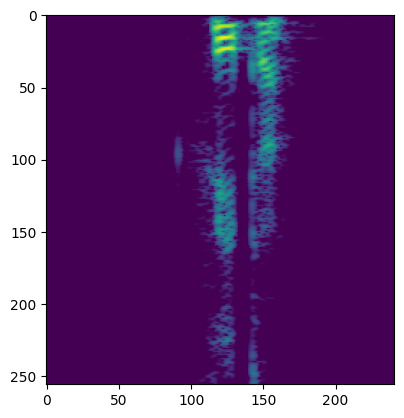

In [9]:
# Load example data
signal, label = swahili_train[10]
print(f"example signal: {signal.shape}, label: {label}")
plt.imshow(signal[0])

## CNN model

In [10]:
# Resnet, pretrained
model_resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
model_resnet.conv1=nn.Conv2d(1, model_resnet.conv1.out_channels, 
                      kernel_size=model_resnet.conv1.kernel_size[0], 
                      stride=model_resnet.conv1.stride[0], 
                      padding=model_resnet.conv1.padding[0])
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 12) # 12 output classes for 12 words

In [11]:
resnet = model_resnet.to(device)
summary(resnet, (1, 200, 241)) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 121]           3,200
       BatchNorm2d-2         [-1, 64, 100, 121]             128
              ReLU-3         [-1, 64, 100, 121]               0
         MaxPool2d-4           [-1, 64, 50, 61]               0
            Conv2d-5           [-1, 64, 50, 61]          36,864
       BatchNorm2d-6           [-1, 64, 50, 61]             128
              ReLU-7           [-1, 64, 50, 61]               0
            Conv2d-8           [-1, 64, 50, 61]          36,864
       BatchNorm2d-9           [-1, 64, 50, 61]             128
             ReLU-10           [-1, 64, 50, 61]               0
       BasicBlock-11           [-1, 64, 50, 61]               0
           Conv2d-12           [-1, 64, 50, 61]          36,864
      BatchNorm2d-13           [-1, 64, 50, 61]             128
             ReLU-14           [-1, 64,

## Training the model

In [12]:
def create_data_loaders(train_data, batch_size, val_split, shuffle_dataset, random_seed):
    """
    Data Loader for training and validation set from the same custom Dataset for trainings data.
    
    Input:
    train_data (Custom Dataset with signal and label)
    batch_size
    val_split (split size)
    shuffle_dataset (bool, if dataset is shuffled for train/val-split)
    random_seed
    
    Returns:
    train_dataloader
    val_dataloader
    """
    dataset_size = len(train_data)
    indices = list(range(dataset_size))
    split = int(np.floor(val_split * dataset_size))
    if shuffle_dataset:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_indices, val_indices = indices[split:], indices[:split]

    # Creating data samplers and loaders:
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                               sampler=train_sampler)
    val_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                                    sampler=val_sampler)
    
    return train_dataloader, val_dataloader


def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, scheduler, device):
    for input, target in train_data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        train_prediction = model(input)
        train_loss = loss_fn(train_prediction, target)

        # backpropagate error and update weights
        optimiser.zero_grad()
        train_loss.backward()
        optimiser.step()

    
    for input, target in val_data_loader:
        input, target = input.to(device), target.to(device)

        # calculate loss
        val_prediction = model(input)
        val_loss = loss_fn(val_prediction, target)
    
    
    scheduler.step()
    print(f"training loss: {train_loss.item()}, validation loss: {val_loss.item()}")


def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, scheduler, device, epochs):
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, scheduler, device)
        print("---------------------------")
    print("Finished training")

In [13]:
swahili_train = SwahiliDataset(ANNOTATIONS_FILE,
                               AUDIO_DIR,
                               AUDIO_TRANSFORM,
                               SAMPLE_RATE,
                               NUM_SAMPLES,
                               device)
    
train_dataloader, val_dataloader = create_data_loaders(swahili_train, 
                                                       BATCH_SIZE, 
                                                       VAL_SPLIT, 
                                                       SHUFFLE_DATASET, 
                                                       RANDOM_SEED)

# construct model and assign it to device
resnet = model_resnet.to(device)

# initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(resnet.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=3, gamma=0.1, verbose=True)

# train model
train(resnet, train_dataloader, val_dataloader, loss_fn, optimiser, scheduler, device, EPOCHS)

# save model
torch.save(resnet.state_dict(), "resnet_v2_spec.pth")
print("Trained model saved at resnet_v2_spec.pth")

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 1
Adjusting learning rate of group 0 to 1.0000e-03.
training loss: 0.4264336824417114, validation loss: 0.3532233238220215
---------------------------
Epoch 2
Adjusting learning rate of group 0 to 1.0000e-03.
training loss: 0.7479892373085022, validation loss: 0.3186556100845337
---------------------------
Epoch 3
Adjusting learning rate of group 0 to 1.0000e-04.
training loss: 0.03681091219186783, validation loss: 0.19666321575641632
---------------------------
Epoch 4
Adjusting learning rate of group 0 to 1.0000e-04.
training loss: 0.1467667669057846, validation loss: 0.2651524543762207
---------------------------
Epoch 5
Adjusting learning rate of group 0 to 1.0000e-04.
training loss: 0.2131737768650055, validation loss: 0.2946628928184509
---------------------------
Epoch 6
Adjusting learning rate of group 0 to 1.0000e-05.
training loss: 0.16299845278263092, validation loss: 0.21753542125225067
---------------------------
Epoc

## Competition Test Set

In [14]:
class SwahiliDataset_Testset(SwahiliDataset):
    """
    Custom Dataset for test data.
    The label is not known for the test data, therefore the Dataset for training data cannot be used.
    This Dataset inherits the functions defined in SwahiliDataset.
    The same transformations are applied to the signal.
    The getitem function is adjusted to return only the signal.
    """
    def __init__(self,
                 annotations_file,
                 audio_dir,
                 transformation,
                 target_sample_rate,
                 num_samples,
                 device):
        self.annotations = pd.read_csv(annotations_file)
        self.audio_dir = audio_dir
        self.device = device
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        signal, sr = torchaudio.load(audio_sample_path)
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._mix_down_if_necessary(signal)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        signal = self.transformation(signal)
        return signal

In [15]:
def predict_testset(model, data_loader):
    """
    Predictions on the test set
    Returns:
    predictions with values between 0 and 1 due to added softmax layer.
    """
    model.eval()
    with torch.no_grad():
        for input in data_loader:
            input = input.to(device)
            predictions = nn.Softmax(dim=1)(model(input))
        # Tensor (1, 10) -> [ [0.1, 0.01, ..., 0.6] ]
    return predictions

def create_test_data_loader(test_data):
    """
    test data loader with full test data set as batch
    """
    dataset_size = len(test_data)
    test_dataloader = DataLoader(test_data, batch_size=dataset_size)
    return test_dataloader

In [16]:
# load back the model
resnet = model_resnet.to(device)
state_dict = torch.load("resnet_v2_spec.pth")
resnet.load_state_dict(state_dict)

TEST_ANNOTATIONS_FILE = "data/Test.csv"

swahili_test = SwahiliDataset_Testset(TEST_ANNOTATIONS_FILE,
                                      AUDIO_DIR,
                                      AUDIO_TRANSFORM,
                                      SAMPLE_RATE,
                                      NUM_SAMPLES,
                                      "cpu")

test_dataloader = create_test_data_loader(swahili_test)

predicted = predict_testset(resnet, test_dataloader)
print(f"Predicted: {predicted}")

Predicted: tensor([[4.1770e-06, 1.5575e-06, 1.4050e-06,  ..., 2.7642e-07, 5.9579e-06,
         9.3024e-04],
        [8.6177e-06, 2.3448e-06, 4.1617e-06,  ..., 1.2969e-06, 3.5505e-05,
         9.9955e-01],
        [7.7253e-03, 3.5064e-03, 2.0147e-02,  ..., 2.6538e-03, 1.1227e-02,
         7.9924e-01],
        ...,
        [9.8910e-01, 1.5456e-04, 2.0553e-04,  ..., 7.3204e-04, 2.0548e-03,
         3.6964e-04],
        [3.3280e-06, 2.3386e-06, 2.0560e-06,  ..., 1.0990e-06, 5.7111e-06,
         9.9990e-01],
        [1.4899e-05, 1.2027e-06, 3.0611e-06,  ..., 2.0842e-06, 3.2444e-05,
         2.2035e-05]])


In [17]:
predicted.shape

torch.Size([1800, 12])

In [18]:
# Create submission DataFrame
class_mapping = ['hapana',
                  'kumi',
                  'mbili',
                  'moja',
                  'nane',
                  'ndio',
                  'nne',
                  'saba',
                  'sita',
                  'tano',
                  'tatu',
                  'tisa']

test = pd.read_csv('data/Test.csv')
submission = pd.DataFrame({'Word_id': test['Word_id']})
for i, label in enumerate(class_mapping):
    submission[label] = predicted[:,i].numpy()
submission.head()

,Word_id,hapana,kumi,mbili,moja,nane,ndio,nne,saba,sita,tano,tatu,tisa
0,id_jp2pxl0r84ya.wav,0.000004,0.000002,0.000001,0.000016,0.000007,0.000045,0.000014,0.000003,0.998971,2.764155e-07,0.000006,0.000930
1,id_ndduqqvthbpx.wav,0.000009,0.000002,0.000004,0.000006,0.000013,0.000006,0.000013,0.000004,0.000360,1.296941e-06,0.000036,0.999546
2,id_36oxymxfcm6q.wav,0.007725,0.003506,0.020147,0.011722,0.004154,0.019079,0.003372,0.032276,0.084893,2.653792e-03,0.011227,0.799244
3,id_ue9b0to760pg.wav,0.000437,0.000016,0.000016,0.000002,0.000039,0.000026,0.000002,0.000062,0.000003,9.993451e-01,0.000035,0.000016
4,id_prja4oprb914.wav,0.000146,0.000044,0.000065,0.000065,0.998558,0.000040,0.000489,0.000071,0.000090,1.928133e-04,0.000178,0.000061


In [19]:
submission.to_csv('data/submission_torch_resnet18_normal-spec_12epoch_lrschedule.csv', index=False)